In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim
import yaml
import pickle
import pdb
from torch.utils.data import DataLoader
from data import dataset
from trainer import Trainer
from tqdm import tqdm

Carico il configuratore che tiene traccia di tutte le informazioni generali 

In [5]:
with open("/home/andrea/Scrivania/Tesi/leonardo/config_env.yaml", 'r') as f:
    config_env = yaml.safe_load(f)
id_model = "GAT_LSTMseq2seq"
with open(os.path.join(config_env['paths']['config'], f"{id_model}.yaml"), 'r') as f:
    config = yaml.safe_load(f)
    
config.update(config_env)

if 'epochs' in config_env['setting'].keys():
    config['training']['epochs'] = config_env['setting']['epochs']


In [9]:
past_step = config['setting']['past_step']
future_step = config['setting']['future_step']

with open( os.path.join(config['paths']['data'], config['setting']['dataset'],f"{past_step}_{future_step}.pkl"), 'rb') as f:
    dataset = pickle.load(f) 

config['dataset']['in_feat_past'] =  dataset.x[0].shape[-1]
config['dataset']['in_feat_future'] =  dataset.x_fut[0].shape[-1]
len_train = int(len(dataset)*config['dataset']['train_split'])
len_val = int(len(dataset)*config['dataset']['val_split'])
len_test = len(dataset)-(len_train+len_val)
df_train, df_val, df_test = torch.utils.data.random_split(dataset=dataset, lengths = [len_train, len_val, len_test])
dl_train = DataLoader(dataset=df_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(dataset=df_val, batch_size=batch_size, shuffle=True)
x_past, x_fut, y, adj = next(iter(dl_train))
config['setting']['in_feat_past'] = x_past.shape[-1]
config['setting']['in_feat_future'] = x_fut.shape[-1]
print(x_past.shape)
print(x_fut.shape)
print(y.shape)


torch.Size([4, 30, 107, 21])
torch.Size([4, 50, 107, 7])
torch.Size([4, 107, 50])


In [10]:
class embedding_layer(torch.nn.Module):
    def __init__(self,
                 categorical:list,
                 dim_categorical:int):
        
        super(embedding_layer, self).__init__()
        self.embedding = nn.ModuleList([nn.Embedding(categorical[i], dim_categorical) for i in range(len(categorical))])
    def forward(self, x):
    
        out = 0.0
        for i in range(len(self.embedding)):
            out += self.embedding[i](x[:,:,:, i])    
        return out.float()
        
class pre_processing(torch.nn.Module):
    def __init__(self,
                 in_feat:int, 
                 out_feat:int, 
                 dropout:float):
        
        super(pre_processing, self).__init__()
        self.linear = nn.Sequential(nn.Dropout(dropout),
                                    nn.Linear(in_features = in_feat, out_features = 128),
                                    nn.ReLU(), 
                                    nn.Linear(in_features = 128, out_features = 128),
                                    nn.ReLU(),
                                    nn.Linear(in_features = 128, out_features = out_feat, bias=False))
        
    def forward(self, x):  
        return self.linear(x.float())

class my_gat(torch.nn.Module):

    def __init__(self, 
                 in_channels: int, 
                 out_channels: int):
        super(my_gat, self).__init__()

        self.in_channels = in_channels
        self.a1 = nn.Parameter(torch.randn(out_channels))
        self.a2 = nn.Parameter(torch.randn(out_channels))
        self.emb = nn.Linear(in_features = in_channels, 
                             out_features = out_channels, 
                             bias = False)
        

    def forward(self,
                x0: tuple) -> torch.tensor:
        
        x, A = x0   
        x_emb = self.emb(x)
        _, _, N, _ = x_emb.shape
        ## <a,(h_i||h_j)>
        top = torch.einsum('bsnj,j->bsn', x_emb, self.a1)
        bot = torch.einsum('bsnj,j->bsn', x_emb, self.a2)
        z = F.leaky_relu(top.unsqueeze(-1)+bot.unsqueeze(-1).transpose(-2,-1))

        # Apply the mask to fill values in the input tensor
        # sigmoid(Pi*X*W)
        pi = F.softmax(z.masked_fill(A == 0., -float('infinity')), -1)
        x = F.sigmoid(torch.einsum('bpik,bpkj->bpij', pi, x_emb))        
        return (x, A)

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM weights and biases
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_g = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, hidden):
        h_prev, c_prev = hidden
        
        # Concatenate input and previous hidden state
        combined = torch.cat((x, h_prev), dim=-1)

        # Compute the input, forget, output, and cell gates
        i = torch.sigmoid(self.W_i(combined))
        f = torch.sigmoid(self.W_f(combined))
        o = torch.sigmoid(self.W_o(combined))
        g = torch.tanh(self.W_g(combined))

        # Update the cell state and hidden state
        c = f * c_prev + i * g
        h = o * torch.tanh(c)

        return h, c
        
        
class GAT_LSTMseq2seq(torch.nn.Module):
    def __init__(self, 
                 in_feat_past:int, 
                 in_feat_fut:int, 
                 past: int, 
                 future: int,
                 categorical_past:list,
                 categorical_future:list,
                 device, 
                 out_preprocess:int = 128, 
                 dropout: float = 0.1, 
                 dim_categorical_past:int = 64, 
                 dim_categorical_future:int = 128, 
                 concat:bool = True,
                 num_layer_gnn_past:int = 1,
                 num_layer_gnn_future:int = 1,
                 out_gnn: int = 128, 
                 hidden_gnn:int = 256,
                 hidden_lstm: int = 128, 
                 hidden_propagation:int = 128):
        
        super(GAT_LSTMseq2seq, self).__init__()
        
        self.in_feat_past = in_feat_past         # numero di features di ogni nodo prima del primo GAT        
        self.in_feat_past = in_feat_fut
        self.past = past 
        self.future = future
        self.hidden_gnn = hidden_gnn
        self.hidden_lstm = hidden_lstm
        self.device = device
        self.categorical_past = categorical_past
        self.categorical_fut = categorical_future
        
        
        ########## PREPROCESSING PART #############        
        self.embedding_past = embedding_layer(categorical = categorical_past,
                                            dim_categorical = dim_categorical_past)
        if len(categorical_future)>0:
            self.embedding_future = embedding_layer(categorical = categorical_future,
                                                    dim_categorical = dim_categorical_future)
        
        in_feat_preprocessing_past = in_feat_past + dim_categorical_past - len(categorical_past)
        self.pre_processing_past = pre_processing(in_feat = in_feat_preprocessing_past, 
                                                 out_feat = out_preprocess, 
                                                 dropout = dropout)
        in_feat_preprocessing_fut = in_feat_fut + dim_categorical_future - len(categorical_future)
        self.pre_processing_fut = pre_processing(in_feat = in_feat_preprocessing_fut, 
                                                 out_feat = out_preprocess, 
                                                 dropout = dropout)
        ########## GNN ############# 
        ##### past
        layers = []
        for i in range(num_layer_gnn_past):
            layers.append(my_gat(in_channels = out_preprocess if i == 0 else hidden_gnn, 
                                 out_channels = out_gnn if i == num_layer_gnn_past-1 else hidden_gnn))            
        self.gnn_past = nn.Sequential(*layers)

        ##### future
        layers = []
        for i in range(num_layer_gnn_future):
            layers.append(my_gat(in_channels = out_preprocess if i == 0 else hidden_gnn, 
                                 out_channels = out_gnn if i == num_layer_gnn_future-1 else hidden_gnn))            
        self.gnn_future = nn.Sequential(*layers)

        ######### LSTM ################
        # sia l'embedding del passato che quello del futuro hanno la stessa dimensionalità
        # quindi poso usare lo stesso lstm e prendere come output gli ultimi `fut_step` 
        self.lstm = LSTMCell(input_size = out_gnn, 
                             hidden_size = hidden_lstm)
        self.decoding = nn.Sequential(nn.Linear(in_features = hidden_lstm, 
                                                out_features = hidden_propagation), 
                                      nn.ReLU(), 
                                      nn.Linear(in_features = hidden_propagation,
                                                out_features = hidden_propagation),
                                      nn.ReLU(),
                                      nn.Linear(in_features = hidden_propagation,
                                                out_features = 1))
               
    def forward(self, x_past, x_fut, adj):        
        ########### pre-processing dei dati ##########
        ##### past 
        emb = self.embedding_past(x_past[:,:,:,-len(self.categorical_past):].int())
        x_past = torch.cat((x_past[:,:,:,:-len(self.categorical_past)], emb), -1)
        x_past = self.pre_processing_past(x_past)
        
        ##### future
        if len(self.categorical_fut)>0:
            emb = self.embedding_future(x_fut[:,:,:,-len(self.categorical_fut):].int())
            x_fut = torch.cat((x_fut[:,:,:,:-len(self.categorical_fut)], emb), -1)    
        x_fut = self.pre_processing_fut(x_fut)
        
        ########## GNN processing ######################
        x_past, _ = self.gnn_past((x_past, adj))
        x_fut, _ = self.gnn_future((x_fut, adj))

        ########## LSTM part ###########################
        x_lstm = torch.cat((x_past, x_fut), 1)
        batch_size, seq_len, nodes, features = x_lstm.size()
        h, c = [torch.zeros(batch_size, nodes, self.hidden_lstm).to(x_past.device)] * 2
        out = []
        for t in range(seq_len):
            h, c = self.lstm(x_lstm[:, t], (h, c)) 
            if t >= self.past:
                out.append(self.decoding(c))
        out = torch.cat(out, -1)
        return out

device = torch.device("cpu")       
model = GAT_LSTMseq2seq(in_feat_past = config['setting']['in_feat_past'],
                        in_feat_fut = config['setting']['in_feat_future'],
                        past = past_step,
                        future = future_step,
                        categorical_past = config['categorical'][config['setting']['dataset']]['past'],
                        categorical_future = config['categorical'][config['setting']['dataset']]['future'],
                        device = device).to(device)
yh = model(x_past.to(model.device),x_fut.to(model.device), adj[0].to(model.device))
yh.shape

torch.Size([4, 107, 50])

## Loss of the model
As always, the model must perform well on average on all points. 
$$
\frac{1}{n|T|}\sum_{i=1}^n\sum_{j}^{|T|}\left|f\left(t_j,x_{i,t_j}\right)-\hat{f}\left(t_j,x_{i,t_j}\right)\right|
$$
In addition, it is important that the model did not have, at worst, too high an error.
$$
\left(\int_X\left(\int_T|f(t,x)-\hat{f}(t,x)|\,dt\right)^p\,dx\right)^{\frac{1}{p}}\to\max_{x\in X}\int_T|f(t,x)-\hat{f}(t,x)|\,dt
$$

In [12]:
#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAT_LSTMseq2seq(in_feat_past = config['setting']['in_feat_past'],
                        in_feat_fut = config['setting']['in_feat_future'],
                        past = past_step,
                        future = future_step,
                        categorical_past = config['categorical'][config['setting']['dataset']]['past'],
                        categorical_future = config['categorical'][config['setting']['dataset']]['future'],
                        device = device).to(device)
PATH = os.path.join(config_env['paths']['models'], f"GAT_LSTMseq2seq_{past_step}_{future_step}.pt")
model.load_state_dict(torch.load(PATH))
optimizer = optim.Adam(model.parameters(), 
                       lr = 1e-3, 
                       weight_decay=2e-4)
def linfty(y, yh, gamma = 1.0, alpha=1e-1, beta=1e-0):
    out = 0.5*F.l1_loss(y,yh, reduction = "mean")
    out += gamma*F.mse_loss(y,yh, reduction = "mean")
    out += alpha*torch.max(torch.abs(y-yh))
    out += beta*(torch.sum(F.relu(-yh)))
    return out

In [ ]:
trainer = Trainer(model = model.to(device), 
                  PATH = os.path.join(config['paths']['models'], "testing.pt"), 
                  optimizer = optimizer, 
                  gamma_scheduler = 0.85, 
                  step= 300, 
                  loss_function = linfty)

trainer.fit(train_loader=dl_train, val_loader=dl_val, epochs=30)

  0%|                                                                           | 0/1 [00:00<?, ?it/s]

In [24]:
def plot(model, 
         config:yaml,
         loss_training: list, 
         loss_validation: list, 
         name:str,
         dl_train: DataLoader,
         dl_val: DataLoader, 
         show = False, 
         n_nodes:int=30):

    fig = px.line({"epochs": range(1,len(loss_training)+1), 
                                   "train": loss_training, 
                                   "validation": loss_validation}, 
                                  x = "epochs", 
                                  y = ["train", "validation"], 
                                  title= f"training loss for {name}")
    fig.add_vline(x = np.argsort(loss_validation)[0]+1)
    fig.add_hline(y = np.min(loss_validation))
    fig.write_html(os.path.join(config['paths']['fig'], config['setting']['dataset'], f"loss_gnn_{name}.html"))
    if show:
        fig.show()
    model = model.cpu()
    model.device = torch.device('cpu')
    
    x_past_train, x_fut_train, y_train, adj_train = next(iter(dl_train))
    x_past_val, x_fut_val, y_val, adj_val = next(iter(dl_val))
    yh_train = model(x_past_train.float().to(model.device), x_fut_train.float().to(model.device), adj_train[0].to(model.device)).detach().numpy()
    yh_val = model(x_past_val.float().to(model.device), x_fut_val.float().to(model.device), adj_val[0].to(model.device)).detach().numpy()

    n_nodes = min(y_val.shape[1], n_nodes)
    fig, ax = plt.subplots(nrows = n_nodes, 
                           ncols = 2, 
                           constrained_layout = True,
                           figsize = (20, 3*n_nodes))
    
    for day in range(n_nodes):
        ax[day, 0].plot(yh_train[0,day], label = "estimate")
        ax[day, 0].plot(y_train[0,day], label ="real")
    
        ax[day, 1].plot(yh_val[0,day], label = "estimate")
        ax[day, 1].plot(y_val[0,day], label ="real")
        ax[day, 0].legend()
        ax[day, 1].legend()
    
        ax[day, 0].title.set_text(f"node {day +1} train")
        ax[day, 1].title.set_text(f"node {day +1} validation")
    fig.suptitle(' Comparison between estimation and reality ', fontsize=20) 
    
    path = os.path.join(config['paths']['fig'], config['setting']['dataset'], f"{name}.png")
    plt.savefig(path)
    if show:
        plt.show()
    plt.close(fig)

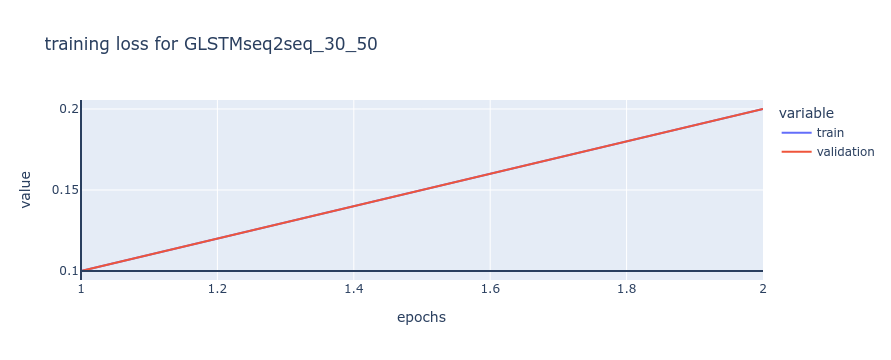

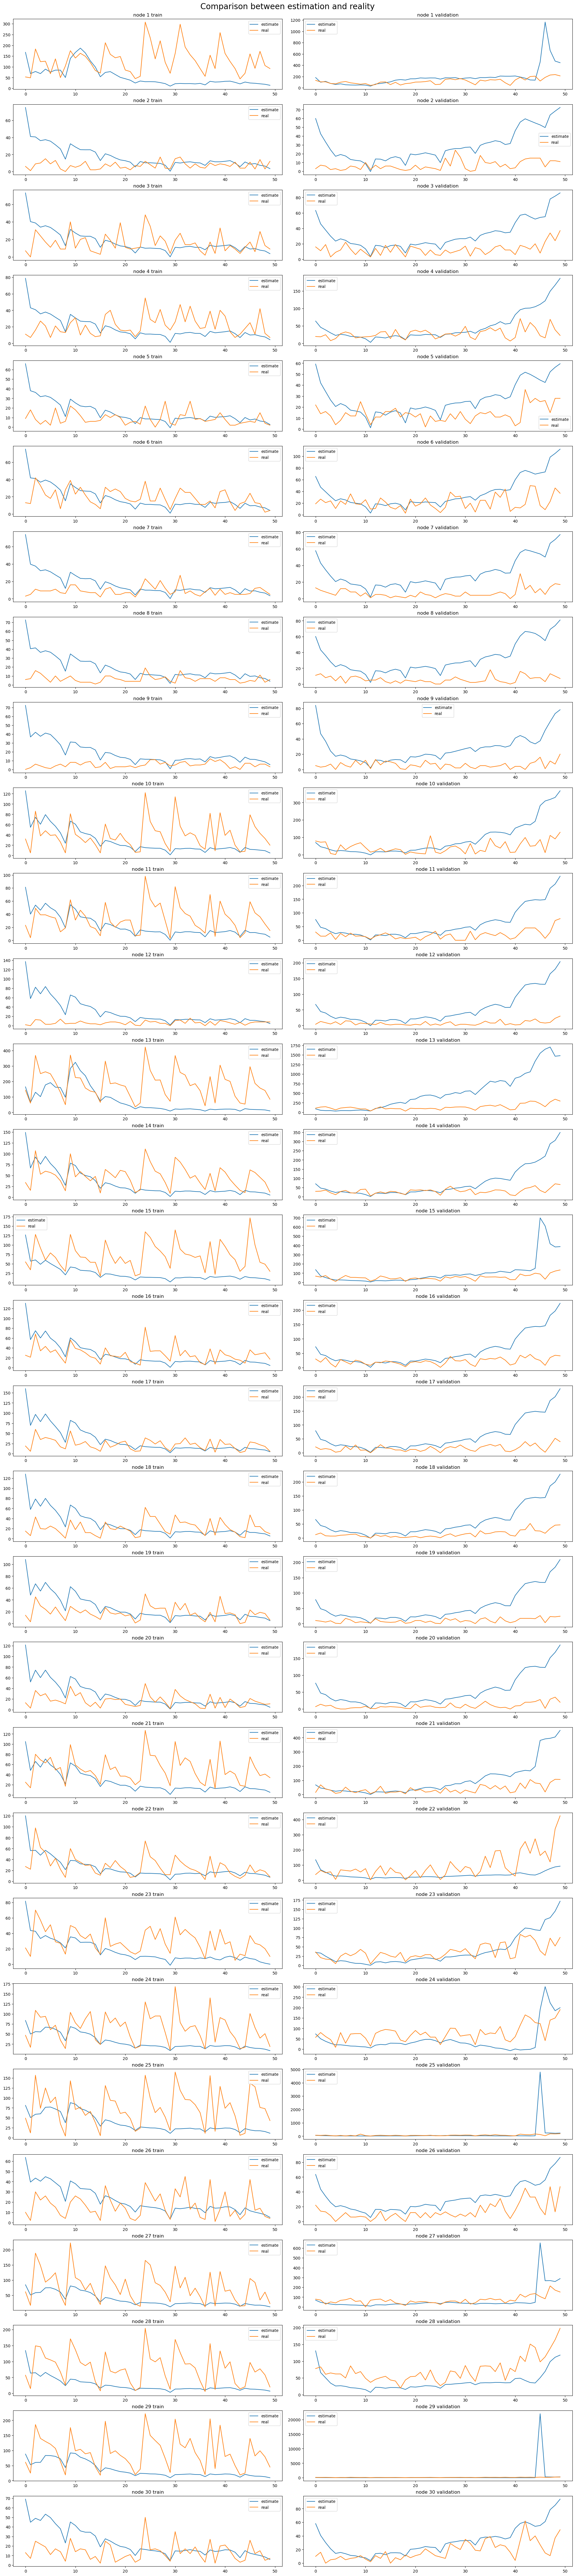

In [25]:
plot(model,
     config,
     [0.1,0.2], 
     [0.1,0.2], 
     dl_train=dl_train,
     dl_val=dl_val,
     name=f"GLSTMseq2seq_{past_step}_{future_step}", 
     show = True)